## **Drive Access**

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [294]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

from glob import glob
import xml.etree.ElementTree as ET
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [229]:
sys.path.append('/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/')
from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

**Annotation & Helper** functions

In [230]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)

import xml.etree.ElementTree as ET


def read_all_annotations(root_dir, convert_labels_to_int=True):
    """
    root_dir: پوشه‌ای که فایل‌های .xml در آن قرار دارند
    convert_labels_to_int: اگر True باشد، labelها به عدد تبدیل می‌شوند
    """
    annos = {}
    label_to_int = {}
    label_counter = 0

    xml_files = glob(os.path.join(root_dir, '*.xml'))

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text.strip()
        objects = root.findall('object')

        if not objects:
            continue

        boxes = []
        labels = []

        for obj in objects:
            label = obj.find('name').text.strip()

            if convert_labels_to_int:
                if label not in label_to_int:
                    label_to_int[label] = label_counter
                    label_counter += 1
                label = label_to_int[label]  # تبدیل به عدد

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        annos[filename] = {
            'boxes': boxes,
            'labels': labels
        }

    return annos


def bbox_to_r1c1r2c2(bbox):
    x = bbox['x']
    y = bbox['y']
    w = bbox['width']
    h = bbox['height']
    return [y, x, y + h, x + w]  # [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor.
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)

    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws

    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]

    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale

    # scale image
    img = cv2.resize(img, (w, h))

    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)

    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [231]:
DATA_DIR = "/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets"

train_dir = f'{DATA_DIR}/train'
print(train_dir)
valid_dir = f'{DATA_DIR}/valid'
print(valid_dir)
#anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train
/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/valid


### Files structure

In [232]:
print(os.listdir(DATA_DIR))

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid', 'test', 'annotations']


In [233]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.xml', '609_png.rf.71155561209d46822d238361ccf00977.xml', '1867_png.rf.158504767e0c1c729eb956e284226bc5.xml', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.xml', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.xml', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.xml', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.xml', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.xml', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.xml', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.xml', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.xml', '221_png.rf.f0e320d4667864be19d370937374209c.xml', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.xml', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.xml', '663_png.rf.ff214636bf86b07138c0413031532af8.xml', '674_png.rf.b15aa49eb971813387542ae9ea664609.xml', '633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.xml', '1456_png.rf.2e60df59

In [234]:
files = glob(f'{DATA_DIR}/train/*.jpg')

files[:5]

['/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/515_png.rf.f9121afe38c38ff6d75595a923992326.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/94_png.rf.416143d4efdad648b71312a9541e0a4c.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/767_png.rf.fd084782d91a43632664e9e0e600c144.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1863_png.rf.3ba919653775064d6b9f80b8a002b0f3.jpg']

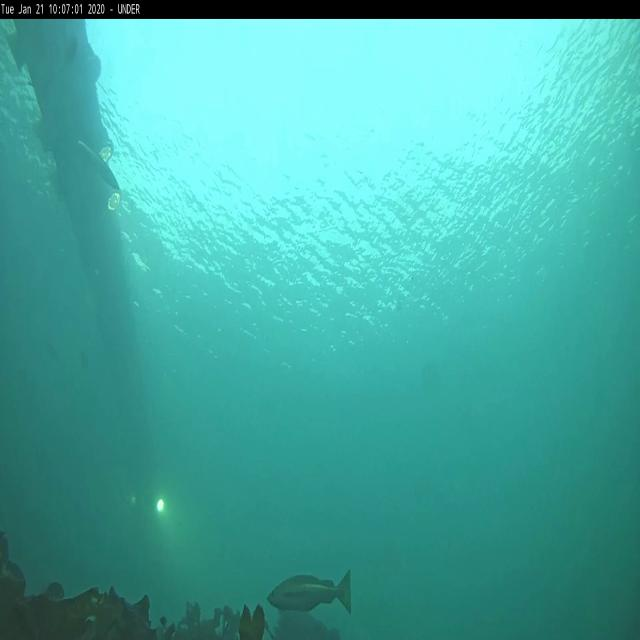

In [235]:
Image.open(files[3])

### Fish Dataset

Creat a simple class for images

In [236]:
#چون فایل اطلاعات عکس ها و عکس ها با هم قاطی اند و پوشه بندی جداگانه نشده اند
#عکس ها یعنی عکس هر ماهی تو پوشه خودش، اول یه کلاس ساده میسازیم کهفقط عکس ها رو لیست کنه بعد میفرستیم به کلاسFishdataset
from torchvision.datasets.folder import default_loader

class SimpleImageDataset:
    def __init__(self, root):
        self.imgs = [(f, 0) for f in glob(os.path.join(root, '*.jpg'))]
        self.classes = ['fish']  # مقدار اولیه فقط


In [237]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch


class FishDataset(Dataset):
    def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
        """
        ds: مجموعه تصاویر (از ImageFolder)
        bboxes: دیکشنری شامل 'boxes' و 'labels' برای هر تصویر
        classes: لیست کلاس‌ها
        class_to_idx: دیکشنری نگاشت نام کلاس به اندیس
        sz: اندازه نهایی تصویر
        """
        self.imgs = ds.imgs  # لیست تاپل‌های (مسیر, label)
        self.classes = classes
        self.bboxes = bboxes
        self.class_to_idx = class_to_idx
        self.sz = sz
        self.image_paths = [img[0] for img in ds.imgs]  # ذخیره مسیرهای تصاویر

        # نمایش کلاس‌های موجود
        print("کلاس‌های موجود:")
        print(self.classes)
        print("\nclass_to_idx:")
        print(self.class_to_idx)

        # پیدا کردن برچسب‌های منحصر به فرد در دیتاست
        all_labels = set()
        for bbox_info in self.bboxes.values():
            all_labels.update(map(str, bbox_info['labels']))

        print("\nبرچسب‌های موجود در دیتاست:", all_labels)

        # برچسب‌های گم‌شده
        missing_labels = all_labels - set(self.class_to_idx.keys())
        if missing_labels:
            print("\n⚠️ برچسب‌های گم‌شده:", missing_labels)
            # اضافه کردن خودکار (اختیاری)
            for idx, label in enumerate(missing_labels, start=len(self.class_to_idx)):
                self.class_to_idx[label] = idx
                print(f"اضافه شد: {label} -> {idx}")

        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img_path, _ = self.imgs[index]
        img_name = os.path.basename(img_path)

        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        w_scale = self.sz / w
        h_scale = self.sz / h

        image = self.tfms(image)

        boxes = []
        labels = []

        if img_name in self.bboxes:
            bbox_info = self.bboxes[img_name]
            for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
                # تبدیل به مختصات نسبی [0-1]
                x1 = box[0] / w
                y1 = box[1] / h
                x2 = box[2] / w
                y2 = box[3] / h

                boxes.append([x1, y1, x2, y2])

                # تبدیل برچسب با بررسی وجود در class_to_idx
                try:
                    # بررسی هم برای عددی و هم رشته‌ای
                    if isinstance(label, str):
                        label_idx = self.class_to_idx[label]
                    else:
                        label_idx = self.class_to_idx[str(label)]
                    labels.append(label_idx)
                except KeyError:
                    print(f"⚠️ هشدار: برچسب {label} (نوع: {type(label)}) در class_to_idx وجود ندارد!")
                    continue  # یا مقدار پیش‌فرض قرار دهید

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long)

        return image, labels, boxes, (w, h), img_path

    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [238]:
def extract_classes_from_xml(dataset_dirs):
    """
    dataset_dirs: لیستی از مسیرها به پوشه‌های train و valid
    خروجی: دیکشنری class_to_idx
    """
    classes = set()

    for dataset_dir in dataset_dirs:
        for file in os.listdir(dataset_dir):
            if file.endswith('.xml'):
                xml_path = os.path.join(dataset_dir, file)
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    for obj in root.findall('object'):
                        name = obj.find('name').text
                        classes.add(name)
                except Exception as e:
                    print(f"خطا در فایل {file}: {e}")

    sorted_classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted_classes)}
    return class_to_idx


In [344]:
# def collate_fn(batch):
#     """
#     نسخه ایمن‌تر برای collate_fn
#     """
#     batch = [x for x in batch if x is not None]  # حذف نمونه‌های نامعتبر
#     if not batch:
#         return torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()

#     imgs, lbls, bbs, sizes, paths = zip(*batch)

#     return (
#         torch.stack(imgs, 0),
#         lbls,  # لیست تنسورها
#         bbs,   # لیست تنسورها
#         sizes,
#         paths  # اختیاری
#     )

#     return imgs, lbls, bbs, sizes  # یا اگر به مسیرها نیاز دارید: return imgs, lbls, bbs, sizes, img_paths




def collate_fn(batch):
    """
    نسخه اصلاح شده برای مدیریت اندازه‌های متفاوت
    """
    batch = [x for x in batch if x is not None]
    if not batch:
        return torch.Tensor(), [], [], [], []

    imgs, lbls, bbs, sizes, paths = zip(*batch)

    # تصاویر را stack می‌کنیم (همه اندازه یکسان دارند)
    images = torch.stack(imgs, 0)

    # لیبل‌ها و bboxها را به صورت لیست نگه می‌داریم (عدم استفاده از stack)
    return (
        images,
        list(lbls),  # لیست تنسورها با اندازه‌های مختلف
        list(bbs),   # لیست تنسورها با اندازه‌های مختلف
        sizes,
        paths
    )

Creat Validation Data

In [345]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

In [346]:
# خواندن annotation و کلاس‌ها
bb_json = read_all_annotations(train_dir)

# استخراج لیست یکتا از کلاس‌ها
all_classes = sorted(list(set(label for v in bb_json.values() for label in v['labels'])))

# ساخت دیکشنری class_to_idx
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

# دیتاست و دیتالودر آموزش
train_data = SimpleImageDataset(train_dir)
train_ds = FishDataset(train_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)
# دیتاست و دیتالودر اعتبارسنجی
valid_data = SimpleImageDataset(valid_dir)
valid_ds = FishDataset(valid_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn)


کلاس‌های موجود:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

برچسب‌های موجود در دیتاست: {'4', '0', '5', '1', '2', '3', '6'}

⚠️ برچسب‌های گم‌شده: {'0', '4', '5', '1', '2', '3', '6'}
اضافه شد: 0 -> 7
اضافه شد: 4 -> 8
اضافه شد: 5 -> 9
اضافه شد: 1 -> 10
اضافه شد: 2 -> 11
اضافه شد: 3 -> 12
اضافه شد: 6 -> 13
کلاس‌های موجود:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, '0': 7, '4': 8, '5': 9, '1': 10, '2': 11, '3': 12, '6': 13}

برچسب‌های موجود در دیتاست: {'4', '0', '5', '1', '2', '3', '6'}


Check annotations

In [347]:
print(f"تعداد کل کلیدها در bb_json: {len(bb_json)}")
print(f"نوع داده bb_json: {type(bb_json)}")
print("کلیدها:", list(bb_json.keys()))
print("Image Name:",list(bb_json.keys())[5])  # نمایش 5 تصویر اول

تعداد کل کلیدها در bb_json: 1315
نوع داده bb_json: <class 'dict'>
کلیدها: ['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.jpg', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.jpg', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.jpg', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.jpg', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.jpg', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.jpg', '221_png.rf.f0e320d4667864be19d370937374209c.jpg', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.jpg', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.jpg', '663_png.rf.ff214636bf86b07138c0413031532af8.jpg', '674_png.rf.b15aa49eb971813387542ae9ea664609.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.jpg'

In [348]:
print(bb_json['1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg'])
print(bb_json['609_png.rf.71155561209d46822d238361ccf00977.jpg'])

{'boxes': [[230, 175, 299, 219], [2, 274, 30, 363]], 'labels': [2, 3]}
{'boxes': [[434, 515, 461, 538]], 'labels': [1]}


### Visulaize data

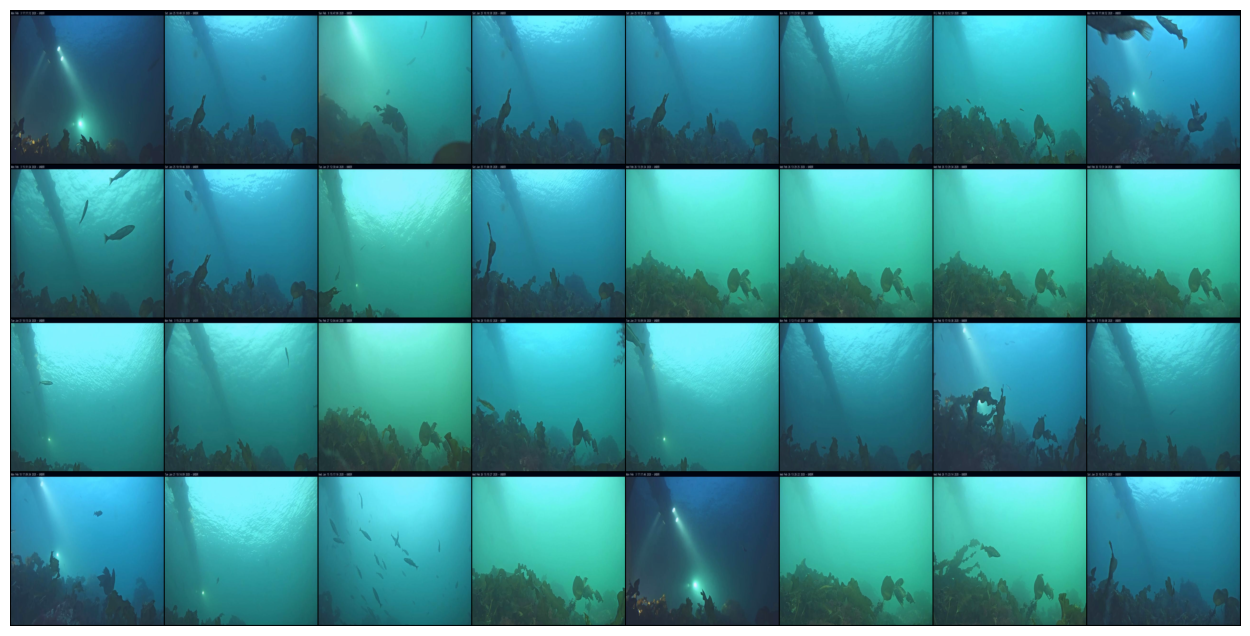

In [362]:
# import torchvision
# import matplotlib.pyplot as plt
# import numpy as np

# # تابع ساده برای نمایش تصاویر
# def imshow_grid(images, nrow=8, figsize=(16, 8)):
#     """
#     نمایش تصاویر به صورت گرید
#     پارامترها:
#         images: تنسور تصاویر با شکل (B, C, H, W)
#         nrow: تعداد تصاویر در هر ردیف
#         figsize: سایز شکل خروجی
#     """
#     # ایجاد گرید و نرمالایز خودکار
#     grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True, scale_each=True)

#     # تبدیل به numpy و تغییر ابعاد برای matplotlib
#     np_grid = grid.numpy().transpose((1, 2, 0))

#     # نمایش
#     plt.figure(figsize=figsize)
#     plt.imshow(np_grid)
#     plt.axis('off')
#     plt.show()

# # دریافت یک بچ از دیتالودر
# dataiter = iter(train_dl)
# images, *_ = next(dataiter)  # فقط تصاویر را بگیرید، بقیه را نادیده بگیرید

# # نمایش تصاویر
# imshow_grid(images, nrow=8)



# def imshow_grid(images, nrow=8, figsize=(16, 8)):
#     """
#     نمایش تصاویر به صورت گرید
#     """
#     # اطمینان از اینکه فقط تصاویر را دریافت می‌کنیم
#     if isinstance(images, (list, tuple)):
#         images = images[0]  # فقط المان اول (تصاویر) را بگیر

#     grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True, scale_each=True)
#     np_grid = grid.numpy().transpose((1, 2, 0))

#     plt.figure(figsize=figsize)
#     plt.imshow(np_grid)
#     plt.axis('off')
#     plt.show()

import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow_grid(batch, nrow=8, figsize=(16, 8)):
    """
    نمایش تصاویر از یک batch از دیتالودر
    پارامترها:
        batch: خروجی از دیتالودر (تصاویر باید در المان اول باشند)
        nrow: تعداد تصاویر در هر ردیف
        figsize: سایز شکل خروجی
    """
    # استخراج تصاویر از batch
    images = batch[0]  # المان اول همیشه تصاویر هستند

    # ایجاد گرید و نرمالایز خودکار
    grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True, scale_each=True)

    # تبدیل به numpy و تغییر ابعاد برای matplotlib
    np_grid = grid.numpy().transpose((1, 2, 0))

    # نمایش
    plt.figure(figsize=figsize)
    plt.imshow(np_grid)
    plt.axis('off')
    plt.show()

# دریافت و نمایش یک batch
dataiter = iter(train_dl)
batch = next(dataiter)
imshow_grid(batch, nrow=8)

In [350]:
import matplotlib.pyplot as plt
# import torch
# import numpy as np
# file_name = train_ds.imgs[5][0]  # فرض بر این که مسیر فایل تصویر در train_ds.imgs ذخیره شده باشد
# print(file_name)



📁 نمونه شماره 411
📷 مسیر تصویر: /content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1569_png.rf.04e9a48a43a58637388e7d8126ee35ce.jpg
📄 مسیر XML: /content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1569_png.rf.04e9a48a43a58637388e7d8126ee35ce.xml
📏 ابعاد اصلی: 640x640
🏷️ برچسب‌ها: [11]
🟦 Bounding Boxهای خام از دیتاست:
[[0.5546875, 0.8187500238418579, 0.629687488079071, 0.921875]]
🟩 Bounding Boxهای واقعی از XML:
[[355, 524, 403, 590]]


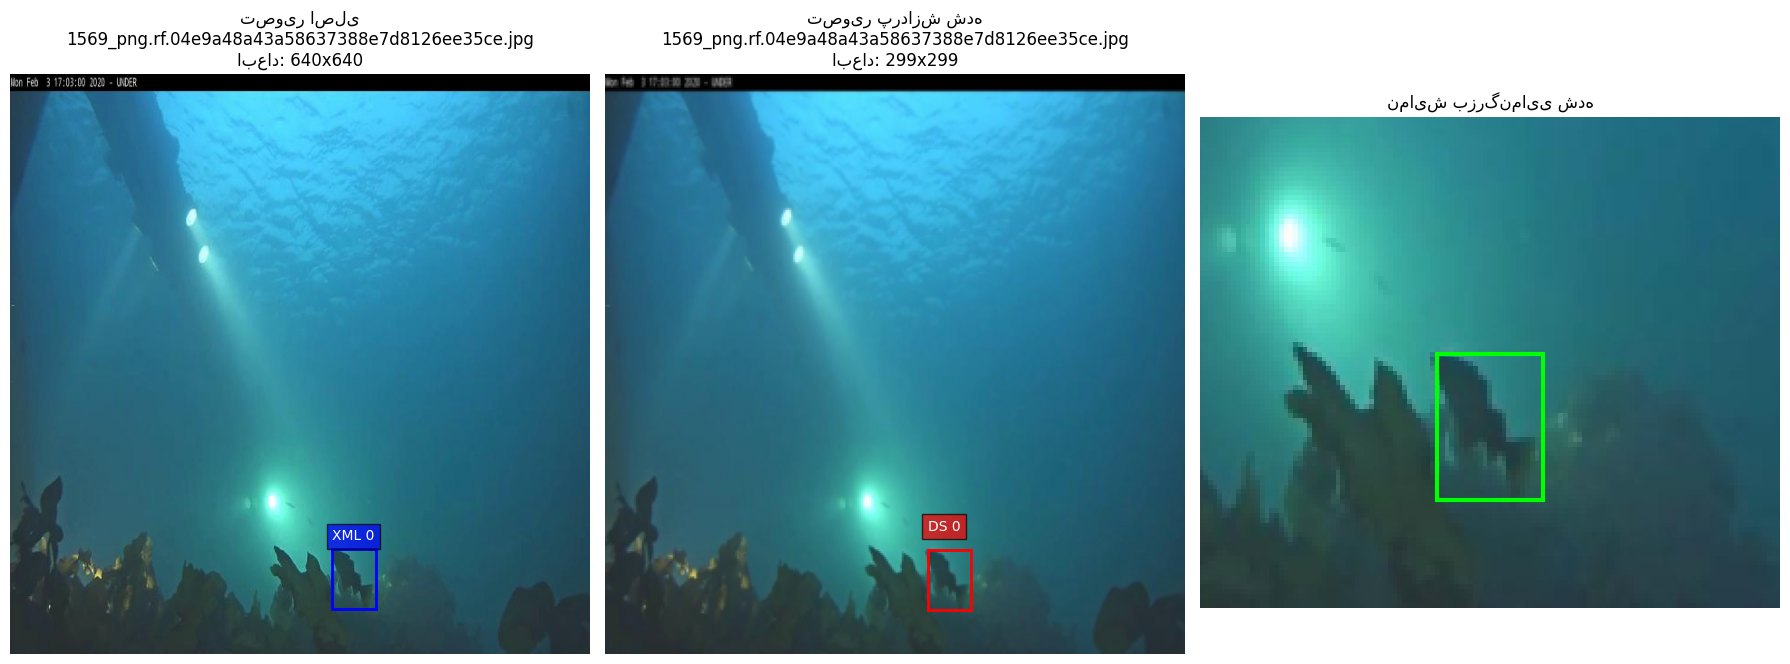


🔍 مقایسه دقیق مختصات:

Box 0:
  دیتاست -> x: [244.8, 275.6] (عرض: 30.8px)
           y: [165.9, 188.3] (ارتفاع: 22.4px)
  XML    -> x: [165.9, 188.3] (عرض: 22.4px)
           y: [244.8, 275.6] (ارتفاع: 30.8px)
  اختلاف -> x: 79.0px, y: 79.0px


In [351]:
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

def show_sample_with_debug(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    نمایش کامل یک نمونه با تمام اطلاعات دیباگ
    """
    # دریافت نمونه از دیتاست
    img, labels, bboxes, (orig_w, orig_h), img_path = dataset[idx]
    img_name = os.path.basename(img_path)
    xml_path = img_path.replace('.jpg', '.xml').replace('.png', '.xml')

    # چاپ اطلاعات دیباگ
    print("\n" + "="*80)
    print(f"📁 نمونه شماره {idx}")
    print(f"📷 مسیر تصویر: {img_path}")
    print(f"📄 مسیر XML: {xml_path}")
    print(f"📏 ابعاد اصلی: {orig_w}x{orig_h}")
    print(f"🏷️ برچسب‌ها: {labels.tolist()}")
    print(f"🟦 Bounding Boxهای خام از دیتاست:\n{bboxes.tolist()}")

    # خواندن مستقیم از XML برای مقایسه
    xml_boxes = []
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                xmin = int(float(bndbox.find('xmin').text))
                ymin = int(float(bndbox.find('ymin').text))
                xmax = int(float(bndbox.find('xmax').text))
                ymax = int(float(bndbox.find('ymax').text))
                xml_boxes.append([xmin, ymin, xmax, ymax])

            print(f"🟩 Bounding Boxهای واقعی از XML:\n{xml_boxes}")
        except Exception as e:
            print(f"⚠️ خطا در خواندن XML: {e}")
            xml_boxes = []
    else:
        print("⚠️ فایل XML یافت نشد!")
        xml_boxes = []

    # Unnormalize تصویر
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # محاسبه نسبت تغییر اندازه
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    # ایجاد figure
    plt.figure(figsize=(18, 8))

    # 1. نمایش تصویر اصلی با باکس‌های اصلی
    plt.subplot(1, 3, 1)
    orig_img = Image.open(img_path).convert('RGB')
    plt.imshow(orig_img)
    plt.title(f'تصویر اصلی\n{img_name}\nابعاد: {orig_w}x{orig_h}')

    if xml_boxes:
        for i, box in enumerate(xml_boxes):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                fill=False, edgecolor='blue', linewidth=2))
            plt.text(xmin, ymin-10, f'XML {i}', color='white',
                    bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')


    # 2. نمایش تصویر پردازش شده با باکس‌های دیتاست
    plt.subplot(1, 3, 2)
    plt.imshow(img)

    for i, bbox in enumerate(bboxes):
        # اصلاح مهم: جابجایی x و y در این بخش
        x1, y1, x2, y2 = bbox  # تغییر از y1,x1,y2,x2 به x1,y1,x2,y2
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='red', linewidth=2))
        plt.text(xmin, ymin-10, f'DS {i}', color='white',
                bbox=dict(facecolor='red', alpha=0.7))

    plt.title(f'تصویر پردازش شده\n{img_name}\nابعاد: {img.shape[1]}x{img.shape[0]}')
    plt.axis('off')

    # 3. نمایش بزرگنمایی شده اگر باکس‌ها کوچک هستند
    plt.subplot(1, 3, 3)
    plt.imshow(img)

    if len(bboxes) > 0:
        x1, y1, x2, y2 = bboxes[0]  # تغییر این خط
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='lime', linewidth=3))

        # بزرگنمایی روی ناحیه باکس
        zoom_margin = 50
        plt.xlim(max(0, xmin-zoom_margin), min(img.shape[1], xmax+zoom_margin))
        plt.ylim(min(img.shape[0], ymax+zoom_margin), max(0, ymin-zoom_margin))

        plt.title('نمایش بزرگنمایی شده')
    else:
        plt.title('بدون باکس')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # چاپ مقایسه ای دقیق
    if xml_boxes and len(bboxes) == len(xml_boxes):
        print("\n🔍 مقایسه دقیق مختصات:")
        for i, (ds_box, xml_box) in enumerate(zip(bboxes, xml_boxes)):
            y1, x1, y2, x2 = ds_box
            xmin_ds = x1.item() * img.shape[1]
            ymin_ds = y1.item() * img.shape[0]
            xmax_ds = x2.item() * img.shape[1]
            ymax_ds = y2.item() * img.shape[0]

            xmin_xml = xml_box[0] * scale_x
            ymin_xml = xml_box[1] * scale_y
            xmax_xml = xml_box[2] * scale_x
            ymax_xml = xml_box[3] * scale_y

            print(f"\nBox {i}:")
            print(f"  دیتاست -> x: [{xmin_ds:.1f}, {xmax_ds:.1f}] (عرض: {xmax_ds-xmin_ds:.1f}px)")
            print(f"           y: [{ymin_ds:.1f}, {ymax_ds:.1f}] (ارتفاع: {ymax_ds-ymin_ds:.1f}px)")
            print(f"  XML    -> x: [{xmin_xml:.1f}, {xmax_xml:.1f}] (عرض: {xmax_xml-xmin_xml:.1f}px)")
            print(f"           y: [{ymin_xml:.1f}, {ymax_xml:.1f}] (ارتفاع: {ymax_xml-ymin_xml:.1f}px)")
            print(f"  اختلاف -> x: {abs(xmin_ds-xmin_xml):.1f}px, y: {abs(ymin_ds-ymin_xml):.1f}px")

# مثال استفاده:
show_sample_with_debug(train_ds, 411)  # نمایش اولین نمونه
# show_sample_with_debug(train_ds, 5)  # نمایش نمونه ششم



## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [352]:
import torch.nn.functional as F

class FishModel(nn.Module):
    def __init__(self, num_classes=8):
        super(FishModel, self).__init__()

        # لایه‌های پایه CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # لایه‌های Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # لایه‌های Fully Connected
        self.fc1 = nn.Linear(128 * 37 * 37, 512)  # محاسبه ابعاد بر اساس ورودی 299x299
        self.fc_class = nn.Linear(512, num_classes)  # برای classification
        self.fc_bbox = nn.Linear(512, 4)  # برای bounding box (x1,y1,x2,y2)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass در لایه‌های کانولوشن
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # تبدیل به برداری یک‌بعدی
        x = x.view(x.size(0), -1)

        # لایه‌های Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # خروجی‌های classification و bounding box
        class_out = self.fc_class(x)
        bbox_out = torch.sigmoid(self.fc_bbox(x))  # نرمال‌سازی به محدوده [0,1]

        return class_out, bbox_out

### Loss Function

In [353]:
class FishLoss(nn.Module):
    def __init__(self, cls_weight=1.0, loc_weight=0.5):
        super().__init__()
        self.cls_criterion = nn.CrossEntropyLoss()
        self.loc_criterion = nn.SmoothL1Loss()
        self.cls_weight = cls_weight
        self.loc_weight = loc_weight

    def forward(self, scores, locs, labels, bboxes):
        loss_cls = self.cls_criterion(scores, labels)
        loss_loc = self.loc_criterion(locs, bboxes)
        return self.cls_weight * loss_cls, self.loc_weight * loss_loc

In [354]:
# def train_one_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     running_correct = 0
#     running_loc_error = 0.0

#     for images, labels, bboxes, _ in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         bboxes = bboxes.to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         class_preds, bbox_preds = model(images)

#         # محاسبه loss
#         loss_class = F.cross_entropy(class_preds, labels)
#         loss_bbox = F.mse_loss(bbox_preds, bboxes)
#         total_loss = loss_class + loss_bbox

#         # Backward pass
#         total_loss.backward()
#         optimizer.step()

#         # آمارگیری
#         running_loss += total_loss.item()
#         _, predicted = torch.max(class_preds, 1)
#         running_correct += (predicted == labels).sum().item()
#         running_loc_error += F.l1_loss(bbox_preds, bboxes).item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = running_correct / len(train_loader.dataset)
#     epoch_loc_error = running_loc_error / len(train_loader)

#     return epoch_loss, epoch_acc, epoch_loc_error


# def train_one_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     running_correct = 0
#     running_loc_error = 0.0

#     # اصلاح این خط - دریافت 5 مقدار و استفاده از 3 مورد نیاز
#     for images, labels, bboxes, _, _ in train_loader:  # تغییر اینجا
#         images = images.to(device)
#         labels = labels.to(device)
#         bboxes = bboxes.to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         class_preds, bbox_preds = model(images)

#         # محاسبه loss
#         loss_class = F.cross_entropy(class_preds, labels)
#         loss_bbox = F.mse_loss(bbox_preds, bboxes)
#         total_loss = loss_class + loss_bbox

#         # Backward pass
#         total_loss.backward()
#         optimizer.step()

#         # آمارگیری
#         running_loss += total_loss.item()
#         _, predicted = torch.max(class_preds, 1)
#         running_correct += (predicted == labels).sum().item()
#         running_loc_error += F.l1_loss(bbox_preds, bboxes).item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = running_correct / len(train_loader.dataset)
#     epoch_loc_error = running_loc_error / len(train_loader)

#     return epoch_loss, epoch_acc, epoch_loc_error



def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_loc_error = 0.0

    for batch in train_loader:
        images = batch[0].to(device)
        labels_list = batch[1]  # لیست تنسورها
        bboxes_list = batch[2]  # لیست تنسورها

        # تبدیل لیست به تنسور با padding خودکار
        labels = torch.nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-1).to(device)
        bboxes = torch.nn.utils.rnn.pad_sequence(bboxes_list, batch_first=True, padding_value=0).to(device)

        optimizer.zero_grad()

        # Forward pass
        class_preds, bbox_preds = model(images)

        # محاسبه loss (با در نظر گرفتن padding)
        loss_class = F.cross_entropy(class_preds, labels.view(-1))
        loss_bbox = F.mse_loss(bbox_preds, bboxes)
        total_loss = loss_class + loss_bbox

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # آمارگیری (با در نظر گرفتن padding)
        mask = labels != -1
        running_loss += total_loss.item()
        _, predicted = torch.max(class_preds, 1)
        running_correct += (predicted[mask.view(-1)] == labels.view(-1)[mask.view(-1)]).sum().item()
        running_loc_error += F.l1_loss(bbox_preds[mask], bboxes[mask]).item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_correct / sum(len(l) for l in batch[1])  # تعداد کل نمونه‌های واقعی
    epoch_loc_error = running_loc_error / sum(len(l) for l in batch[1])

    return epoch_loss, epoch_acc, epoch_loc_error

In [355]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FishModel(num_classes=len(all_classes)).to(device)
criterion = FishLoss(cls_weight=1.0, loc_weight=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [356]:
# این کد را قبل از حلقه آموزش اجرا کنید تا ساختار داده را ببینید
sample = next(iter(train_dl))
print(f"تعداد المان‌های برگشتی: {len(sample)}")
print(f"ساختار داده: {[type(x) for x in sample]}")

تعداد المان‌های برگشتی: 5
ساختار داده: [<class 'torch.Tensor'>, <class 'list'>, <class 'list'>, <class 'tuple'>, <class 'tuple'>]


In [363]:
# num_epochs = 10
# best_val_acc = 0.0
# early_stopping_patience = 3
# patience_counter = 0

# for epoch in range(num_epochs):
#     # آموزش
#     train_loss, train_acc, train_loc_error = train_one_epoch(
#         model,
#         train_dl,
#         criterion,
#         optimizer,
#         device
#     )

#     # ارزیابی
#     val_loss, val_acc, val_loc_error = evaluate(
#         model,
#         valid_dl,
#         criterion,
#         device
#     )

#     # چاپ نتایج
#     print(f'Epoch {epoch+1}/{num_epochs}')
#     print(f'Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Loc Error: {train_loc_error:.4f}')
#     print(f'Valid - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Loc Error: {val_loc_error:.4f}\n')

#     # Early stopping و ذخیره مدل
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), 'best_model.pth')
#         patience_counter = 0
#     else:
#         patience_counter += 1

#     # به روزرسانی scheduler (یکبار کافیست)
#     scheduler.step(val_loss)  # یا scheduler.step() اگر ReduceLROnPlateau نیست

#     # Early stopping check
#     if patience_counter >= early_stopping_patience:
#         print(f'Early stopping at epoch {epoch+1}')
#         break

num_epochs = 10
best_val_acc = 0.0
early_stopping_patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    # آموزش
    train_loss, train_acc, train_loc_error = train_one_epoch(
        model,
        train_dl,
        criterion,
        optimizer,
        device
    )

    # ارزیابی
    val_loss, val_acc, val_loc_error = evaluate(
        model,
        valid_dl,
        criterion,
        device
    )

    # چاپ نتایج
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Loc Error: {train_loc_error:.4f}')
    print(f'Valid - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Loc Error: {val_loc_error:.4f}\n')

    # مدیریت بهترین مدل و early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # به روزرسانی scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)  # برای ReduceLROnPlateau
    else:
        scheduler.step()  # برای سایر schedulerها

    # بررسی early stopping
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# بارگذاری بهترین مدل در پایان آموزش
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])

ValueError: Expected input batch_size (32) to match target batch_size (544).

### Predicting bounding boxes

In [ ]:
# load weights
# model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

In [301]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)

ValueError: too many values to unpack (expected 4)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>